In [19]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Random 2d data

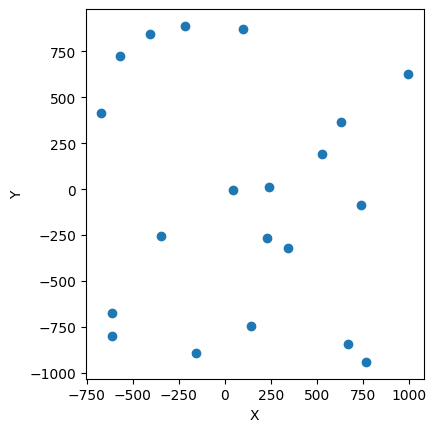

In [20]:
x_min, x_max = -1000, 1000
y_min, y_max = -1000, 1000

num_points = 20
points = np.random.uniform([x_min, y_min], [x_max, y_max], (num_points, 2))

# # def generate_clusters(num_clusters, points_per_cluster, spread):
#     all_points = []
#     for _ in range(num_clusters):
#         cluster_center = np.random.uniform(x_min, x_max, size=2)
#         cluster_points = cluster_center + np.random.normal(0, spread, size=(points_per_cluster, 2))
#         all_points.append(cluster_points)
    
#     return np.vstack(all_points)

# num_clusters = 5
# points_per_cluster = 5
# spread = 75 

# points = generate_clusters(num_clusters, points_per_cluster, spread)
# num_points = num_clusters * points_per_cluster

x = points[:, 0]
y = points[:, 1]
plt.scatter(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Normal (Euclidean) distance

In [21]:
if len(points) < 2000:
    diff = points[:, np.newaxis, :] - points[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff ** 2, axis=2))
    print(distances[:5, :5])

def dist(i, j):
    if len(points) < 2000:
        return distances[i, j]
    return np.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2)

[[   0.         1146.9661881  1934.34564947  934.12199671 1212.04996138]
 [1146.9661881     0.          862.48623969 1174.69470415  577.99938595]
 [1934.34564947  862.48623969    0.         1582.36100745 1308.92254586]
 [ 934.12199671 1174.69470415 1582.36100745    0.         1606.13732102]
 [1212.04996138  577.99938595 1308.92254586 1606.13732102    0.        ]]


Algorithm

In [22]:
permutation = np.random.permutation(num_points)
if len(points) < 2000:
    max_d = np.max(distances)
else:
    max_d = np.sqrt((x_max-x_min)**2 + (y_max-y_min)**2) 
log_delta = 0
delta = 1
while(delta <= 2*max_d):
    delta *= 2
    log_delta += 1

print(delta, log_delta)

r_0 = np.random.uniform(0.5, 1)
r = r_0 * 2**np.arange(log_delta+2)

8192 13


In [23]:
class Node:
    def __init__(self, center, level, parent, S):
        self.center = center
        self.level = level
        self.parent = parent
        self.S = S
        self.x = 0
        self.y = 0
        self.childrens = set()

In [24]:
g = {}
g[0] = Node(points[permutation[0]], log_delta, 0, set(range(num_points)))
where = {}

def construct_tree(v):
    if(len(g[v].S) == 1):
        where[list(g[v].S)[0]] = v
        return
    i = g[v].level
    S = g[v].S
    for j in permutation:
        B = set()
        for k in S:
            if dist(j, k) < r[i-1]:
                B.add(k)
        if B:
            curr = len(g)
            g[curr] = Node(points[j], i-1, v, B)
            g[v].childrens.add(curr)
            S = S-B
            construct_tree(curr)

construct_tree(0)


Drawing circles

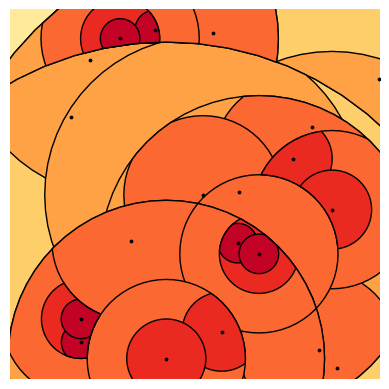

In [25]:
import descartes
import shapely.geometry as sg
from shapely.geometry import Polygon
import heapq

min_level, max_level = log_delta, 0
for v in g:
    min_level = min(min_level, g[v].level)
    max_level = max(max_level, g[v].level)

colormap = plt.cm.BuPu
random_colors = [colormap(i / 1000) for i in range(1000)]
def random_color():
    return random_colors[np.random.randint(500, 750)]

colormap = plt.cm.YlOrRd
colors = [colormap(i / (max_level-min_level+1)) for i in range(max_level-min_level+1)]
colors = colors[::-1]

circles = {}
queue = []
heapq.heappush(queue, (-g[0].level, 0))
ax = plt.gca()
U = Polygon([(x_min, y_min), (x_min, y_max), (x_max, y_min), (x_max, y_min)])

while queue:
    i, v = heapq.heappop(queue)
    i, v = -i, -v
    center = g[v].center
    a = sg.Point(center[0], center[1]).buffer(r[i])
    parent = g[v].parent 
    if v != 0:
        b = circles[parent]
        a = a.intersection(b)
    
    ax.add_patch(descartes.PolygonPatch(a, fc=colors[i-min_level], ec='black'))
    #ax.add_patch(descartes.PolygonPatch(a, fc=random_color(), ec='black'))

    for u in g:
        if g[u].parent == parent and u < v and g[u].level == i:
            b = sg.Point(g[u].center[0], g[u].center[1]).buffer(r[g[u].level])
            a = a.difference(b)
    circles[v] = a
    


    for u in g[v].childrens:
        heapq.heappush(queue, (-g[u].level, -u))

x = points[:, 0]
y = points[:, 1]
plt.scatter(x, y, color='black',s=3)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal', 'box')
ax.axis('off')

plt.show()

Own PCA/t-SNE

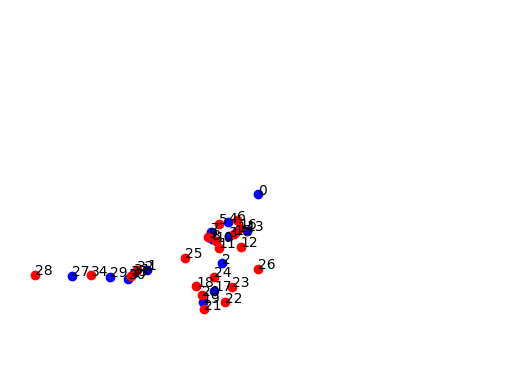

In [26]:
def print_tree(v):
    x = g[v].x
    y = g[v].y
    if(len(g[v].S) == 1):
        plt.scatter(x, y, color='red')
        plt.text(x, y, v)
        return
    else:
        plt.scatter(x, y, color='blue')
        plt.text(x, y, v)
        
    n = len(g[v].childrens)
    D = r[g[v].level]
    angle = np.random.uniform(0, 2*math.pi)
    d_angle = 2*math.pi/n
    for u in g[v].childrens:
        g[u].x = x + D * math.cos(angle)
        g[u].y = y + D * math.sin(angle)
        angle += d_angle
        print_tree(u)
        
print_tree(0)
ax = plt.gca()
ax.set_xlim(math.sqrt(128)*x_min, math.sqrt(128)*x_max)
ax.set_ylim(math.sqrt(128)*y_min, math.sqrt(128)*y_max)
#ax.set_aspect('equal', 'box')
ax.axis('off')
plt.show()

And what do the points look like with these tree-generated labels?

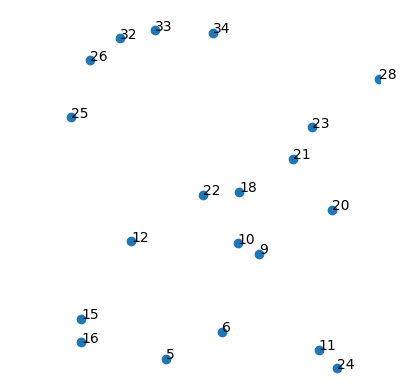

In [29]:
x = points[:, 0]
y = points[:, 1]
plt.scatter(x, y)

for v in where:
    plt.text(points[v][0], points[v][1], where[v])

ax = plt.gca()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal', 'box')
ax.axis('off')
plt.show()

Own t-SNE with the help of netgraph

[0.05       0.54423992]


<function matplotlib.pyplot.show(close=None, block=None)>

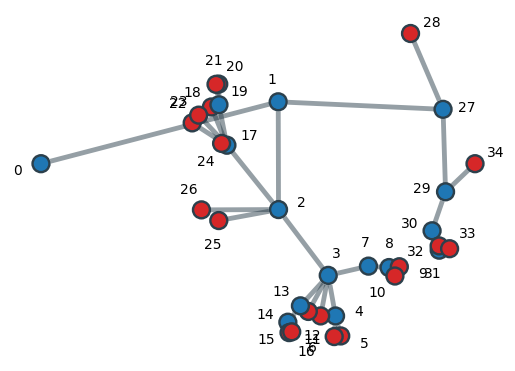

In [30]:
import matplotlib.pyplot as plt
from netgraph import Graph

edge_length = {}

for v in g:
    if v != 0:
        edge_length[(v, g[v].parent)] = r[g[v].level] / r[max_level]
       
edges = list(edge_length.keys())

node_color = {}
for u in where:
    node_color[where[u]] = 'tab:red'
for i in range(len(g)):
    if i not in node_color:
        node_color[i] = 'tab:blue'

fig, ax = plt.subplots()
G = Graph(edges,  
          node_size=2, 
          node_color=node_color, 
          node_labels=True,
          node_label_offset=0.05, 
          node_label_fontdict=dict(fontsize=10), 
          node_layout='geometric',
          node_layout_kwargs=dict(edge_length=edge_length), 
          ax=ax)
ax.set_aspect('equal')
print(G.node_positions[0])
plt.show